In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.base import TransformerMixin

import xgboost as xgb
import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

import mitosheet

import warnings  
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Set notebook mode to work in offline
#pyo.init_notebook_mode()


#configure_plotly_browser_state()

# pyo.init_notebook_mode(connected=True)

In [3]:
from solver import deasolver

In [4]:
# scaler that divides value to the max value of the feature
class MaxValueScaler(TransformerMixin):
    def __init__(self):
        self.max_values = None
    
    def fit(self, X, y=None):
        self.max_values = X.max(axis=0)
        return self
    
    def transform(self, X):
        return X / self.max_values
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X):
        return X * self.max_values

In [5]:
dea_types = ["IO_VRS", "OO_CRS", "OO_VRS", "IO_CRS"]
dea_list = ["US22", "S22","US55","S55"]

for t in dea_list:
    
    exec(f"{t} = pd.read_excel('Data/{t}.xlsx', index_col=0)")
    
    for i, d in enumerate(dea_types):
        
        exec(f"{t}_{d} = pd.read_excel('Data/{t}_Solution.xlsx', index_col=0, header=[1], nrows=1000, skiprows = i * 1000 + i * 2)")
        

In [6]:
df = pd.read_excel('Data/US22.xlsx', index_col=0)
df

Input 1  Input 2  Output 1  Output 2
DMU 0001   397.02   265.18    379.02    537.61
DMU 0002   312.53   209.89    580.46    507.01
DMU 0003   430.04   360.20    556.75    452.77
DMU 0004   473.96   314.18    590.20    383.22
DMU 0005   472.91   211.27    534.18    359.94
...           ...      ...       ...       ...
DMU 0996   577.89   422.77    373.71    260.54
DMU 0997   588.60   296.17    484.61    306.23
DMU 0998   567.06   240.43    398.60    354.88
DMU 0999   543.52   337.50    413.00    343.68
DMU 1000   507.38   225.81    619.62    301.80

[1000 rows x 4 columns]

In [7]:
# deasolver(inputfile = 'Data/US22.xlsx', folder = "Data/New/", out_suffix1="_Sol")

Restricted license - for non-production use only - expires 2023-10-25
20.0
40.0
60.0
80.0
100.0
Solution file saved outputfile


### US22_IO_VRS 

In [8]:
X = df
X.head()

Input 1  Input 2  Output 1  Output 2
DMU 0001   397.02   265.18    379.02    537.61
DMU 0002   312.53   209.89    580.46    507.01
DMU 0003   430.04   360.20    556.75    452.77
DMU 0004   473.96   314.18    590.20    383.22
DMU 0005   472.91   211.27    534.18    359.94

In [9]:
y = pd.read_excel('Data/New/US22_Sol.xlsx', index_col=0).iloc[:,:1]
y.head()

Efficiency_Scores
DMU 0001           0.600978
DMU 0002           1.000000
DMU 0003           0.658441
DMU 0004           0.627703
DMU 0005           0.634704

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
print(X_train.shape)
print(X_test.shape)

(800, 4)
(200, 4)


In [12]:
scaler = MaxValueScaler()
reg_model = LinearRegression()

pipe_lr = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
# print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("Cross Validation metrics: ")
print("neg_root_mean_squared_error:", cross_val_score(pipe_lr, X_train, y_train, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_lr, X_train, y_train, scoring="r2").mean())

print('-' * 20)

# Train the best model on the entire training dataset
print("Holdout metrics: ")
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test.values, y_pred_lr)))
print("r2:", np.sqrt(r2_score(y_test.values, y_pred_lr)))

Cross Validation metrics: 
neg_root_mean_squared_error: -0.03856807380542908
r2: 0.8935402409624675
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.037951013021551794
r2: 0.9474916110465295


In [13]:
scaler = MaxValueScaler()

seed = 1

dt_model = DecisionTreeRegressor(random_state=seed)

pipe_dt = make_pipeline(scaler, dt_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_dt, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_dt, X_train, y_train, scoring="r2").mean())

# specify parameter values to search
params = {}
params['decisiontreeregressor__max_depth'] = list(range(1, 10)) + [None]
params['decisiontreeregressor__min_samples_split'] = list(range(2, 10, 3))
params['decisiontreeregressor__max_features'] = ["auto","log2","sqrt",None]

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_dt, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.04801135286683305
r2: 0.8135911387988257
--------------------
Cross Validation metrics: 
grid.best_score:  -0.04289823597823878
grid.best_params:  {'decisiontreeregressor__min_samples_split': 2, 'decisiontreeregressor__max_features': None, 'decisiontreeregressor__max_depth': None}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93c5ba6040>),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=1))])
grid.r2:  0.8353904086017516
grid.neg_root_mean_squared_error:  -0.04801135286683305
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.04443111929840562
r2: 0.9272741936624445


In [14]:
scaler = MaxValueScaler()
reg_model = KNeighborsRegressor()

pipe_knr = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
# print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("Cross Validation metrics: ")
print("neg_root_mean_squared_error:", cross_val_score(pipe_knr, X_train, y_train, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_knr, X_train, y_train, scoring="r2").mean())

print('-' * 20)

# Train the best model on the entire training dataset
print("Holdout metrics: ")
pipe_knr.fit(X_train, y_train)
y_pred_knr = pipe_knr.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test.values, y_pred_knr)))
print("r2:", np.sqrt(r2_score(y_test.values, y_pred_knr)))

Cross Validation metrics: 
neg_root_mean_squared_error: -0.03693505550429757
r2: 0.9028440171598003
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.03558293268118626
r2: 0.9539936397835259


In [15]:
scaler = MaxValueScaler()

seed = 1

rf_model = RandomForestRegressor(random_state=seed)

pipe_rf = make_pipeline(scaler, rf_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_rf, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_rf, X_train, y_train, scoring="r2").mean())

    # Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

# specify parameter values to search
params = {}
params['randomforestregressor__n_estimators'] = n_estimators
params['randomforestregressor__max_features'] = max_features
params['randomforestregressor__max_depth'] = max_depth
params['randomforestregressor__min_samples_split'] = min_samples_split
params['randomforestregressor__min_samples_leaf'] = min_samples_leaf
params['randomforestregressor__bootstrap'] = bootstrap

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_rf, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.03142392756558172
r2: 0.9275075838363019
--------------------
Cross Validation metrics: 
grid.best_score:  -0.029338223696930215
grid.best_params:  {'randomforestregressor__n_estimators': 1200, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 60, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93c5bf5b20>),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=60, max_features='auto',
                                       n_estimators=1200, random_state=1))])
grid.r2:  0.9331445598378547
grid.neg_root_mean_squared_error:  -0.030841921459732642
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.028979500308756956
r2: 0.9697285694840306


In [16]:
scaler = MaxValueScaler()

seed = 1

gb_model = GradientBoostingRegressor(random_state=seed)

pipe_gb = make_pipeline(scaler, gb_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_gb, X_train, y_train, scoring="r2").mean())

learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_gb, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.02420072327309288
r2: 0.9517623257966044
--------------------
Cross Validation metrics: 
grid.best_score:  -0.016536628513366496
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 1000, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__learning_rate': 0.01}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93c5fe7dc0>),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                           n_estimators=1000, random_state=1,
                                           subsample=0.3))])
grid.r2:  0.9787407490240966
grid.neg_root_mean_squared_error:  -0.017392446525530948
--------------------
Holdout metrics:

In [17]:
scaler = MaxValueScaler()

seed = 1

xgb_model = xgb.XGBRegressor(random_state=seed)

pipe_xgb = make_pipeline(scaler, xgb_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_xgb, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_xgb, X_train, y_train, scoring="r2").mean())

learning_rate = [0.01, 0.1, 0.2, 0.3]
n_estimators = [100, 500, 1000]
max_depth =  [3, 5, 6, 10, 15, 20]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)

# specify parameter values to search
params = {}
params['xgbregressor__learning_rate'] = learning_rate
params['xgbregressor__n_estimators'] = n_estimators
params['xgbregressor__max_depth'] = max_depth
params['xgbregressor__subsample'] = subsample
params['xgbregressor__colsample_bytree'] = colsample_bytree
params['xgbregressor__colsample_bylevel'] = colsample_bylevel

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_xgb, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.029129183375802448
r2: 0.9296508023713933
--------------------
Cross Validation metrics: 
grid.best_score:  -0.019272055550177886
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.2, 'xgbregressor__colsample_bytree': 0.6, 'xgbregressor__colsample_bylevel': 0.4}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93d45d00a0>),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.4, colsample_bynode=1,
                              colsample_bytree=0.6, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.2,
                              max_delta_step=0, max_depth=3, min

In [18]:
scaler = MaxValueScaler()

poly = PolynomialFeatures(degree=3)

# Choose regression method and set hyperparameter
reg_model=LinearRegression()

pipe_plr = make_pipeline(scaler, poly, reg_model)

# cross-validate the pipeline
# print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("Cross Validation metrics: ")
print("neg_root_mean_squared_error:", cross_val_score(pipe_plr, X_train, y_train, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_plr, X_train, y_train, scoring="r2").mean())

print('-' * 20)

# Train the best model on the entire training dataset
print("Holdout metrics: ")
pipe_plr.fit(X_train, y_train)
y_pred_plr = pipe_plr.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test.values, y_pred_plr)))
print("r2:", np.sqrt(r2_score(y_test.values, y_pred_plr)))

Cross Validation metrics: 
neg_root_mean_squared_error: -0.012373137806754721
r2: 0.9882038771631706
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.008566577793038582
r2: 0.9973913903539227


In [19]:
res = pd.DataFrame()
res["Prediction"] = pd.Series(y_pred_plr.ravel())
res.loc[res["Prediction"]>1, "Prediction"] = 1
res["Actual"] = y_test.values
res["Diff"] = res.Prediction - res.Actual
res["Error_Percentage"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Percentage < 5"] = np.abs(res["Error_Percentage"]) < 5  
res = res.round(4)
res

Prediction  Actual    Diff  Error_Percentage  Error_Percentage < 5
0        0.6760  0.6741  0.0019            0.2842                  True
1        0.5995  0.6095 -0.0100           -1.6425                  True
2        0.5306  0.5366 -0.0061           -1.1304                  True
3        0.4849  0.4914 -0.0064           -1.3074                  True
4        0.8679  0.8508  0.0171            2.0123                  True
..          ...     ...     ...               ...                   ...
195      0.2811  0.2890 -0.0078           -2.7077                  True
196      0.5980  0.6001 -0.0022           -0.3589                  True
197      0.5198  0.5207 -0.0009           -0.1740                  True
198      0.4969  0.4967  0.0003            0.0531                  True
199      0.9890  1.0000 -0.0110           -1.1021                  True

[200 rows x 5 columns]

In [20]:
blue = res["Error_Percentage < 5"].sum()
print(blue)
red = len(res["Error_Percentage < 5"]) - (res["Error_Percentage < 5"].sum())
red

199


1

In [21]:
print(res.describe())

       Prediction      Actual        Diff  Error_Percentage
count  200.000000  200.000000  200.000000        200.000000
mean     0.575617    0.575345    0.000271          0.015477
std      0.120151    0.118975    0.008119          1.375064
min      0.281100    0.289000   -0.027200         -3.710900
25%      0.487850    0.490575   -0.004750         -0.900600
50%      0.570150    0.571150   -0.000500         -0.078600
75%      0.656050    0.655225    0.004200          0.710650
max      1.000000    1.000000    0.032700          5.851200


In [22]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9974
p-Value 0.0


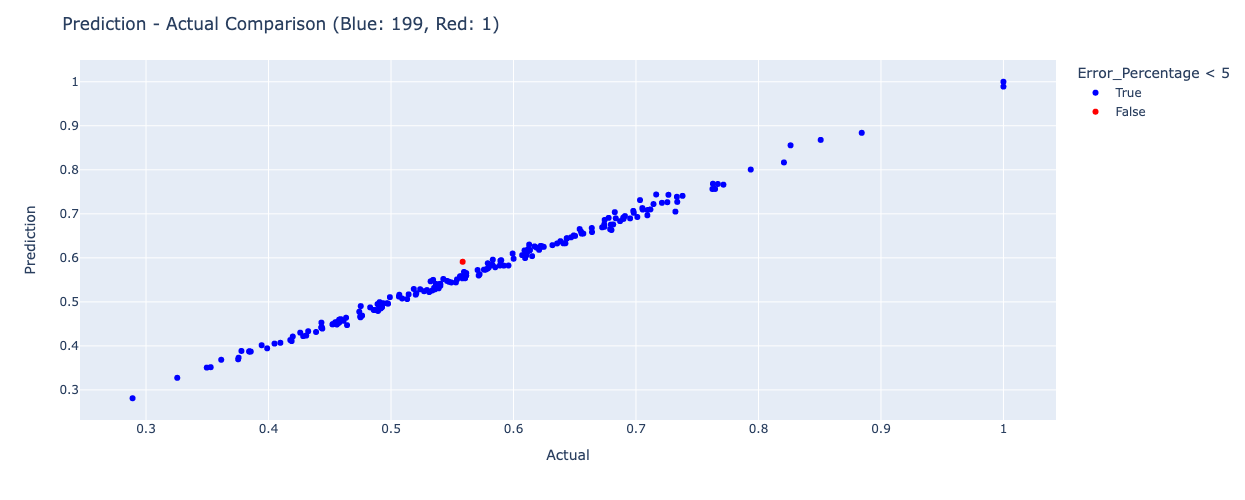

In [23]:
fig = px.scatter(res, x="Actual", y="Prediction", color = "Error_Percentage < 5", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Percentage"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

In [24]:
np.random.seed(1)
tf.random.set_seed(2)

# Scale the data
X_scaler = MaxValueScaler()
y_scaler = MaxValueScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))

ann.add(tf.keras.layers.Dense(units=1))
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')
ann.fit(X_train_scaled, y_train_scaled, batch_size = 32, epochs = 1000, verbose=1)

2023-06-25 17:40:22.071667: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/1000
25/25 [==============================] - 0s 726us/step - loss: 0.0832
Epoch 2/1000
25/25 [==============================] - 0s 629us/step - loss: 0.0143
Epoch 3/1000
25/25 [==============================] - 0s 631us/step - loss: 0.0068
Epoch 4/1000
25/25 [==============================] - 0s 519us/step - loss: 0.0040
Epoch 5/1000
25/25 [==============================] - 0s 518us/step - loss: 0.0029
Epoch 6/1000
25/25 [==============================] - 0s 536us/step - loss: 0.0023
Epoch 7/1000
25/25 [==============================] - 0s 609us/step - loss: 0.0019
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 9/1000
25/25 [==============================] - 0s 571us/step - loss: 0.0013
Epoch 10/1000
25/25 [==============================] - 0s 586us/step - loss: 0.0011
Epoch 11/1000
25/25 [==============================] - 0s 542us/step - loss: 9.5171e-04
Epoch 12/1000
25/25 [==============================] - 0s 548us/step - loss: 8.6874

In [25]:
# Evaluate the model on the test set
y_pred_scaled = ann.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

In [26]:
# print("mean_squared_error:", mean_squared_error(y_test, y_pred)
print("neg_mean_squared_error:", mean_squared_error(y_test, y_pred, squared=False))
print("r2:", r2_score(y_test, y_pred))

neg_mean_squared_error: 0.004332735476748254
r2: 0.9986671481053601


In [27]:
prediction = y_pred

res_ann = pd.DataFrame()
res_ann["Prediction"] = pd.Series(prediction.ravel())
res_ann.loc[res_ann["Prediction"]>1, "Prediction"] = 1
res_ann["Actual"] = y_test.values
res_ann["Diff"] = res_ann.Prediction - res_ann.Actual
res_ann["Error_Percentage"] = ((res_ann.Prediction - res_ann.Actual) / res_ann.Actual) * 100 
res_ann["Error_Percentage < 5"] = np.abs(res_ann["Error_Percentage"]) < 5 
res_ann = res_ann.round(4)

res_ann

Prediction  Actual    Diff  Error_Percentage  Error_Percentage < 5
0        0.6747  0.6741  0.0006            0.0922                  True
1        0.6071  0.6095 -0.0024           -0.3931                  True
2        0.5363  0.5366 -0.0003           -0.0581                  True
3        0.4919  0.4914  0.0006            0.1129                  True
4        0.8486  0.8508 -0.0022           -0.2528                  True
..          ...     ...     ...               ...                   ...
195      0.3231  0.2890  0.0341           11.8001                 False
196      0.5984  0.6001 -0.0017           -0.2775                  True
197      0.5195  0.5207 -0.0012           -0.2266                  True
198      0.4963  0.4967 -0.0004           -0.0710                  True
199      1.0000  1.0000  0.0000            0.0000                  True

[200 rows x 5 columns]

In [28]:
blue = res_ann["Error_Percentage < 5"].sum()
print(blue)
red = len(res_ann["Error_Percentage < 5"]) - (res_ann["Error_Percentage < 5"].sum())
red

198


2

In [29]:
res_ann.describe()

Prediction      Actual        Diff  Error_Percentage
count  200.000000  200.000000  200.000000        200.000000
mean     0.575431    0.575345    0.000082          0.098119
std      0.117326    0.118975    0.004202          1.110828
min      0.323100    0.289000   -0.014400         -1.888000
25%      0.492150    0.490575   -0.001700         -0.285425
50%      0.567450    0.571150   -0.000200         -0.046550
75%      0.656050    0.655225    0.001200          0.225550
max      1.000000    1.000000    0.034100         11.800100

In [30]:
rho, p = stats.spearmanr(res_ann.Prediction, res_ann.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9994
p-Value 0.0


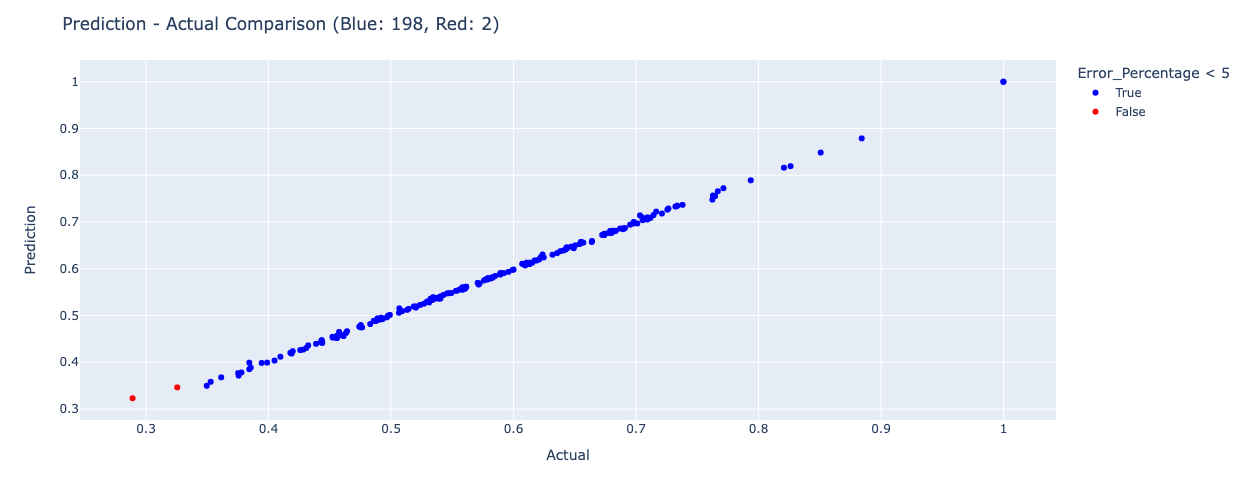

In [31]:
fig = px.scatter(res_ann, x="Actual", y="Prediction", color = "Error_Percentage < 5", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Percentage"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

### S22_IO_VRS 

In [32]:
df = pd.read_excel('Data/S22.xlsx', index_col=0)
df

Input 1  Input 2  Output 1  Output 2
DMU 0001   110.03   366.95     98.95    697.08
DMU 0002   128.76   153.40    101.17    590.34
DMU 0003   126.43   412.75     91.89    513.49
DMU 0004   123.73   395.73     98.75    423.26
DMU 0005   114.73   333.32    110.78    444.36
...           ...      ...       ...       ...
DMU 0996   108.97   779.45    108.62    449.08
DMU 0997   107.07   536.50    107.17    383.14
DMU 0998    98.89   496.85    110.73    478.94
DMU 0999   107.83   593.94    105.72    482.97
DMU 1000   119.56   337.61    110.46    333.54

[1000 rows x 4 columns]

In [33]:
# deasolver(inputfile = 'Data/S22.xlsx', folder = "Data/New/", out_suffix1="_Sol")

20.0
40.0
60.0
80.0
100.0
Solution file saved outputfile


In [34]:
X = df
X.head()

Input 1  Input 2  Output 1  Output 2
DMU 0001   110.03   366.95     98.95    697.08
DMU 0002   128.76   153.40    101.17    590.34
DMU 0003   126.43   412.75     91.89    513.49
DMU 0004   123.73   395.73     98.75    423.26
DMU 0005   114.73   333.32    110.78    444.36

In [35]:
y = pd.read_excel('Data/New/S22_Sol.xlsx', index_col=0).iloc[:,:1]
y.head()

Efficiency_Scores
DMU 0001           0.809955
DMU 0002           0.698887
DMU 0003           0.595224
DMU 0004           0.620998
DMU 0005           0.757204

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
print(X_train.shape)
print(X_test.shape)

(800, 4)
(200, 4)


In [38]:
scaler = MaxValueScaler()
reg_model = LinearRegression()

pipe_lr = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
# print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("Cross Validation metrics: ")
print("neg_root_mean_squared_error:", cross_val_score(pipe_lr, X_train, y_train, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_lr, X_train, y_train, scoring="r2").mean())

print('-' * 20)

# Train the best model on the entire training dataset
print("Holdout metrics: ")
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test.values, y_pred_lr)))
print("r2:", np.sqrt(r2_score(y_test.values, y_pred_lr)))

Cross Validation metrics: 
neg_root_mean_squared_error: -0.0227216218037647
r2: 0.9151398523956488
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.021137626434725658
r2: 0.9606997786808893


In [39]:
scaler = MaxValueScaler()

seed = 1

dt_model = DecisionTreeRegressor(random_state=seed)

pipe_dt = make_pipeline(scaler, dt_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_dt, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_dt, X_train, y_train, scoring="r2").mean())

# specify parameter values to search
params = {}
params['decisiontreeregressor__max_depth'] = list(range(1, 10)) + [None]
params['decisiontreeregressor__min_samples_split'] = list(range(2, 10, 3))
params['decisiontreeregressor__max_features'] = ["auto","log2","sqrt",None]

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_dt, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.027434680401470773
r2: 0.8810106893815058
--------------------
Cross Validation metrics: 
grid.best_score:  -0.02590551103589156
grid.best_params:  {'decisiontreeregressor__min_samples_split': 2, 'decisiontreeregressor__max_features': None, 'decisiontreeregressor__max_depth': None}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93d492c3a0>),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=1))])
grid.r2:  0.8764233573636936
grid.neg_root_mean_squared_error:  -0.027434680401470773
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.027723577177959646
r2: 0.9313679170541442


In [40]:
scaler = MaxValueScaler()
reg_model = KNeighborsRegressor()

pipe_knr = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
# print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("Cross Validation metrics: ")
print("neg_root_mean_squared_error:", cross_val_score(pipe_knr, X_train, y_train, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_knr, X_train, y_train, scoring="r2").mean())

print('-' * 20)

# Train the best model on the entire training dataset
print("Holdout metrics: ")
pipe_knr.fit(X_train, y_train)
y_pred_knr = pipe_knr.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test.values, y_pred_knr)))
print("r2:", np.sqrt(r2_score(y_test.values, y_pred_knr)))

Cross Validation metrics: 
neg_root_mean_squared_error: -0.02740082118170335
r2: 0.87592030564381
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.026813162836867237
r2: 0.935953587334861


In [41]:
scaler = MaxValueScaler()

seed = 1

rf_model = RandomForestRegressor(random_state=seed)

pipe_rf = make_pipeline(scaler, rf_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_rf, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_rf, X_train, y_train, scoring="r2").mean())

    # Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

# specify parameter values to search
params = {}
params['randomforestregressor__n_estimators'] = n_estimators
params['randomforestregressor__max_features'] = max_features
params['randomforestregressor__max_depth'] = max_depth
params['randomforestregressor__min_samples_split'] = min_samples_split
params['randomforestregressor__min_samples_leaf'] = min_samples_leaf
params['randomforestregressor__bootstrap'] = bootstrap

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_rf, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.01807198407932918
r2: 0.9428741540551524
--------------------
Cross Validation metrics: 
grid.best_score:  -0.016792733635707595
grid.best_params:  {'randomforestregressor__n_estimators': 1200, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 60, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93d487ce20>),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=60, max_features='auto',
                                       n_estimators=1200, random_state=1))])
grid.r2:  0.9458541183631158
grid.neg_root_mean_squared_error:  -0.01802821001613624
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.01596199319201789
r2: 0.9777828009595994


In [42]:
scaler = MaxValueScaler()

seed = 1

gb_model = GradientBoostingRegressor(random_state=seed)

pipe_gb = make_pipeline(scaler, gb_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_gb, X_train, y_train, scoring="r2").mean())

learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_gb, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.012976968301852262
r2: 0.9716548375469902
--------------------
Cross Validation metrics: 
grid.best_score:  -0.008466835058533273
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 1000, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__learning_rate': 0.01}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93d45d01c0>),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                           n_estimators=1000, random_state=1,
                                           subsample=0.3))])
grid.r2:  0.9840990257774003
grid.neg_root_mean_squared_error:  -0.009475688582675543
--------------------
Holdout metrics

In [43]:
scaler = MaxValueScaler()

seed = 1

xgb_model = xgb.XGBRegressor(random_state=seed)

pipe_xgb = make_pipeline(scaler, xgb_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_xgb, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_xgb, X_train, y_train, scoring="r2").mean())

learning_rate = [0.01, 0.1, 0.2, 0.3]
n_estimators = [100, 500, 1000]
max_depth =  [3, 5, 6, 10, 15, 20]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)

# specify parameter values to search
params = {}
params['xgbregressor__learning_rate'] = learning_rate
params['xgbregressor__n_estimators'] = n_estimators
params['xgbregressor__max_depth'] = max_depth
params['xgbregressor__subsample'] = subsample
params['xgbregressor__colsample_bytree'] = colsample_bytree
params['xgbregressor__colsample_bylevel'] = colsample_bylevel

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_xgb, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.015072826952519122
r2: 0.9600425286925767
--------------------
Cross Validation metrics: 
grid.best_score:  -0.010503378859073122
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.2, 'xgbregressor__colsample_bytree': 0.6, 'xgbregressor__colsample_bylevel': 0.4}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93a0a94c40>),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.4, colsample_bynode=1,
                              colsample_bytree=0.6, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.2,
                              max_delta_step=0, max_depth=3, min

In [44]:
scaler = MaxValueScaler()

poly = PolynomialFeatures(degree=3)

# Choose regression method and set hyperparameter
reg_model=LinearRegression()

pipe_plr = make_pipeline(scaler, poly, reg_model)

# cross-validate the pipeline
# print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("Cross Validation metrics: ")
print("neg_root_mean_squared_error:", cross_val_score(pipe_plr, X_train, y_train, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_plr, X_train, y_train, scoring="r2").mean())

print('-' * 20)

# Train the best model on the entire training dataset
print("Holdout metrics: ")
pipe_plr.fit(X_train, y_train)
y_pred_plr = pipe_plr.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test.values, y_pred_plr)))
print("r2:", np.sqrt(r2_score(y_test.values, y_pred_plr)))

Cross Validation metrics: 
neg_root_mean_squared_error: -0.006615726520528863
r2: 0.9928383040489461
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.006013460383081228
r2: 0.9968768612204363


In [45]:
res = pd.DataFrame()
res["Prediction"] = pd.Series(y_pred_plr.ravel())
res.loc[res["Prediction"]>1, "Prediction"] = 1
res["Actual"] = y_test.values
res["Diff"] = res.Prediction - res.Actual
res["Error_Percentage"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Percentage < 5"] = np.abs(res["Error_Percentage"]) < 5  
res = res.round(4)
res

Prediction  Actual    Diff  Error_Percentage  Error_Percentage < 5
0        0.7744  0.7738  0.0006            0.0827                  True
1        0.6636  0.6656 -0.0020           -0.3053                  True
2        0.7261  0.7279 -0.0018           -0.2441                  True
3        0.7719  0.7737 -0.0018           -0.2270                  True
4        0.8204  0.8322 -0.0118           -1.4161                  True
..          ...     ...     ...               ...                   ...
195      0.7748  0.7338  0.0411            5.5978                 False
196      0.7237  0.7252 -0.0015           -0.2017                  True
197      0.7683  0.7609  0.0074            0.9660                  True
198      0.7559  0.7576 -0.0017           -0.2192                  True
199      0.6767  0.6767  0.0000            0.0048                  True

[200 rows x 5 columns]

In [46]:
blue = res["Error_Percentage < 5"].sum()
print(blue)
red = len(res["Error_Percentage < 5"]) - (res["Error_Percentage < 5"].sum())
red

199


1

In [47]:
print(res.describe())

       Prediction      Actual        Diff  Error_Percentage
count  200.000000  200.000000  200.000000        200.000000
mean     0.753709    0.753720   -0.000007          0.014281
std      0.075180    0.076336    0.006030          0.776361
min      0.573300    0.571000   -0.027900         -2.871200
25%      0.706975    0.708100   -0.003300         -0.417000
50%      0.753300    0.751300   -0.000700         -0.097050
75%      0.804625    0.805950    0.003000          0.412625
max      0.991900    1.000000    0.041100          5.597800


In [48]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.996
p-Value 0.0


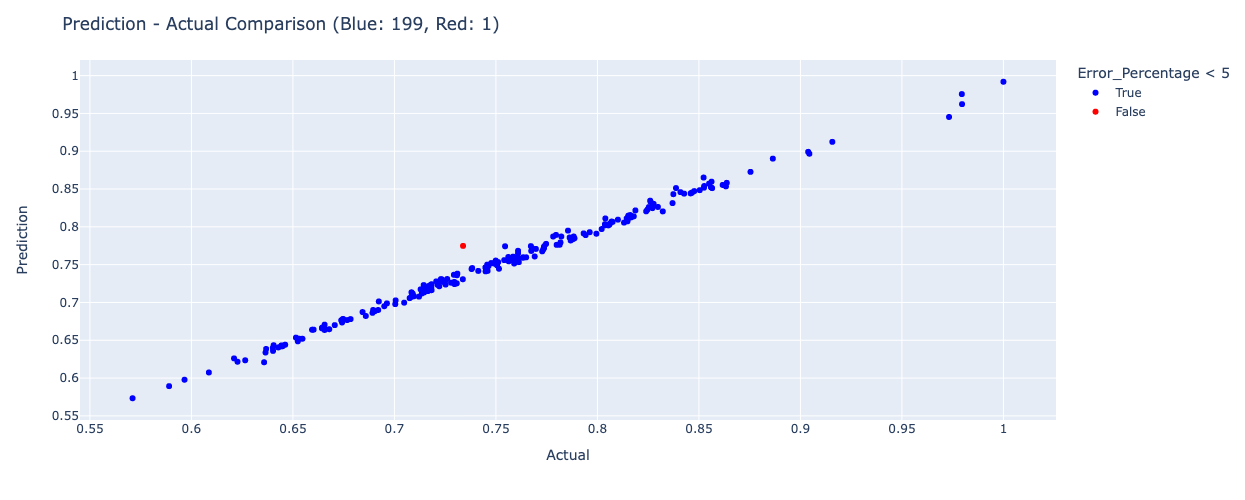

In [49]:
fig = px.scatter(res, x="Actual", y="Prediction", color = "Error_Percentage < 5", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Percentage"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

In [50]:
np.random.seed(1)
tf.random.set_seed(2)

# Scale the data
X_scaler = MaxValueScaler()
y_scaler = MaxValueScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))


ann.add(tf.keras.layers.Dense(units=1))
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')
ann.fit(X_train_scaled, y_train_scaled, batch_size = 32, epochs = 1000, verbose=1)

Epoch 1/1000
25/25 [==============================] - 0s 646us/step - loss: 0.1305
Epoch 2/1000
25/25 [==============================] - 0s 633us/step - loss: 0.0114
Epoch 3/1000
25/25 [==============================] - 0s 534us/step - loss: 0.0071
Epoch 4/1000
25/25 [==============================] - 0s 560us/step - loss: 0.0052
Epoch 5/1000
25/25 [==============================] - 0s 534us/step - loss: 0.0042
Epoch 6/1000
25/25 [==============================] - 0s 581us/step - loss: 0.0035
Epoch 7/1000
25/25 [==============================] - 0s 727us/step - loss: 0.0028
Epoch 8/1000
25/25 [==============================] - 0s 534us/step - loss: 0.0023
Epoch 9/1000
25/25 [==============================] - 0s 523us/step - loss: 0.0018
Epoch 10/1000
25/25 [==============================] - 0s 515us/step - loss: 0.0014
Epoch 11/1000
25/25 [==============================] - 0s 534us/step - loss: 0.0012
Epoch 12/1000
25/25 [==============================] - 0s 540us/step - loss: 9.9815e-

In [51]:
# Evaluate the model on the test set
y_pred_scaled = ann.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

In [52]:
# print("mean_squared_error:", mean_squared_error(y_test, y_pred)
print("neg_mean_squared_error:", mean_squared_error(y_test, y_pred, squared=False))
print("r2:", r2_score(y_test, y_pred))

neg_mean_squared_error: 0.003878177694379655
r2: 0.9974061248558372


In [57]:
prediction = y_pred

res_ann = pd.DataFrame()
res_ann["Prediction"] = pd.Series(prediction.ravel())
res_ann.loc[res_ann["Prediction"]>1, "Prediction"] = 1
res_ann["Actual"] = y_test.values
res_ann["Diff"] = res_ann.Prediction - res_ann.Actual
res_ann["Error_Percentage"] = ((res_ann.Prediction - res_ann.Actual) / res_ann.Actual) * 100 
res_ann["Error_Percentage < 5"] = np.abs(res_ann["Error_Percentage"]) < 5 
res_ann = res_ann.round(4)

res_ann

Prediction  Actual    Diff  Error_Percentage  Error_Percentage < 5
0        0.7752  0.7738  0.0014            0.1778                  True
1        0.6665  0.6656  0.0009            0.1342                  True
2        0.7283  0.7279  0.0004            0.0553                  True
3        0.7757  0.7737  0.0021            0.2675                  True
4        0.8267  0.8322 -0.0055           -0.6657                  True
..          ...     ...     ...               ...                   ...
195      0.7573  0.7338  0.0235            3.2094                  True
196      0.7239  0.7252 -0.0013           -0.1731                  True
197      0.7647  0.7609  0.0037            0.4924                  True
198      0.7591  0.7576  0.0015            0.2017                  True
199      0.6797  0.6767  0.0030            0.4370                  True

[200 rows x 5 columns]

In [58]:
blue = res_ann["Error_Percentage < 5"].sum()
print(blue)
red = len(res_ann["Error_Percentage < 5"]) - (res_ann["Error_Percentage < 5"].sum())
red

200


0

In [59]:
res_ann.describe()

Prediction      Actual        Diff  Error_Percentage
count  200.000000  200.000000  200.000000        200.000000
mean     0.754963    0.753720    0.001245          0.183729
std      0.075023    0.076336    0.003682          0.479586
min      0.572900    0.571000   -0.014800         -1.505900
25%      0.710150    0.708100   -0.000600         -0.071825
50%      0.753850    0.751300    0.001100          0.145200
75%      0.805075    0.805950    0.002925          0.403875
max      0.985300    1.000000    0.023500          3.209400

In [60]:
rho, p = stats.spearmanr(res_ann.Prediction, res_ann.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9989
p-Value 0.0


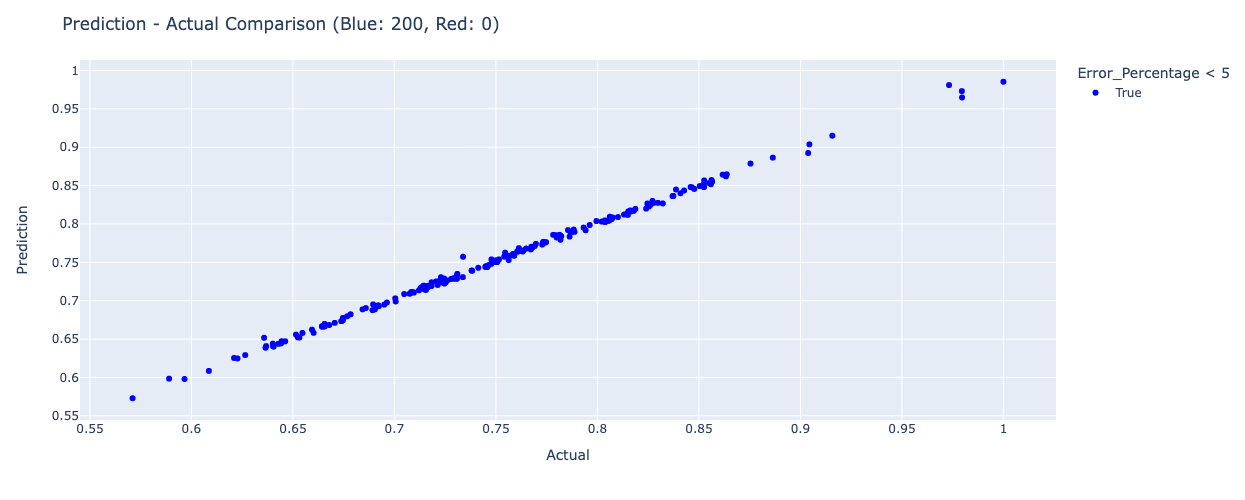

In [61]:
fig = px.scatter(res_ann, x="Actual", y="Prediction", color = "Error_Percentage < 5", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Percentage"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

### US55_IO_VRS 

In [62]:
df = pd.read_excel('Data/US55.xlsx', index_col=0)
df

Input 1  Input 2  Input 3  Input 4  Input 5  Output 1  Output 2  \
DMU 0001   262.93   368.02   311.81   369.14   158.95    373.54    165.68   
DMU 0002   267.81   449.71   300.84   194.85   195.14    312.06    154.78   
DMU 0003   315.52   467.64   249.35   285.36   251.24    224.69    214.17   
DMU 0004   273.62   219.07   245.76   379.23   164.55    345.12    200.72   
DMU 0005   323.65   298.21   369.23   380.81   117.59    406.04    218.08   
...           ...      ...      ...      ...      ...       ...       ...   
DMU 0996   278.92   497.34   292.40   263.17   253.21    349.98    194.55   
DMU 0997   302.55   554.88   339.71   409.44   163.39    378.89    279.95   
DMU 0998   288.62   519.41   302.51   257.01   243.24    275.98    274.91   
DMU 0999   347.93   329.13   187.08   195.77   257.11    293.60    188.74   
DMU 1000   229.75   307.60   293.02   282.45   243.36    207.74    267.35   

          Output 3  Output 4  Output 5  
DMU 0001    625.17    620.95    193.29  
DMU 0002    360.41    510.36    291.05  
DMU 0003    333.71    378.87    180.60  
DMU 0004    466.64    560.33    172.56  
DMU 0005    513.41    583.01    152.26  
...            ...       ...       ...  
DMU 0996    220.20    296.03    221.31  
DMU 0997    437.76    463.17    138.70  
DMU 0998    275.49    340.32    211.50  
DMU 0999    248.37    516.16    298.74  
DMU 1000    495.00    468.12    139.20  

[1000 rows x 10 columns]

In [ ]:
# deasolver(inputfile = 'Data/US55.xlsx', folder = "Data/New/", out_suffix1="_Sol")

In [63]:
X = df
X.head()

Input 1  Input 2  Input 3  Input 4  Input 5  Output 1  Output 2  \
DMU 0001   262.93   368.02   311.81   369.14   158.95    373.54    165.68   
DMU 0002   267.81   449.71   300.84   194.85   195.14    312.06    154.78   
DMU 0003   315.52   467.64   249.35   285.36   251.24    224.69    214.17   
DMU 0004   273.62   219.07   245.76   379.23   164.55    345.12    200.72   
DMU 0005   323.65   298.21   369.23   380.81   117.59    406.04    218.08   

          Output 3  Output 4  Output 5  
DMU 0001    625.17    620.95    193.29  
DMU 0002    360.41    510.36    291.05  
DMU 0003    333.71    378.87    180.60  
DMU 0004    466.64    560.33    172.56  
DMU 0005    513.41    583.01    152.26

In [64]:
y = pd.read_excel('Data/New/US55_Sol.xlsx', index_col=0).iloc[:,:1]
y.head()

Efficiency_Scores
DMU 0001           0.904762
DMU 0002           0.873653
DMU 0003           0.718771
DMU 0004           0.917730
DMU 0005           0.984243

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
print(X_train.shape)
print(X_test.shape)

(800, 10)
(200, 10)


In [67]:
scaler = MaxValueScaler()
reg_model = LinearRegression()

pipe_lr = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
# print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("Cross Validation metrics: ")
print("neg_root_mean_squared_error:", cross_val_score(pipe_lr, X_train, y_train, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_lr, X_train, y_train, scoring="r2").mean())

print('-' * 20)

# Train the best model on the entire training dataset
print("Holdout metrics: ")
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test.values, y_pred_lr)))
print("r2:", np.sqrt(r2_score(y_test.values, y_pred_lr)))

Cross Validation metrics: 
neg_root_mean_squared_error: -0.05255599657744432
r2: 0.6220595708505231
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.04771299242836935
r2: 0.8236209546182807


In [68]:
scaler = MaxValueScaler()

seed = 1

dt_model = DecisionTreeRegressor(random_state=seed)

pipe_dt = make_pipeline(scaler, dt_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_dt, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_dt, X_train, y_train, scoring="r2").mean())

# specify parameter values to search
params = {}
params['decisiontreeregressor__max_depth'] = list(range(1, 10)) + [None]
params['decisiontreeregressor__min_samples_split'] = list(range(2, 10, 3))
params['decisiontreeregressor__max_features'] = ["auto","log2","sqrt",None]

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_dt, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.08069710711861537
r2: 0.06587487335543243
--------------------
Cross Validation metrics: 
grid.best_score:  -0.07306990856228879
grid.best_params:  {'decisiontreeregressor__min_samples_split': 8, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__max_depth': 9}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93c5bc5bb0>),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=9, max_features='auto',
                                       min_samples_split=8, random_state=1))])
grid.r2:  0.17782220369293783
grid.neg_root_mean_squared_error:  -0.07671753409976258
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.0731868358924923
r2: 0.49316536198012034


In [69]:
scaler = MaxValueScaler()
reg_model = KNeighborsRegressor()

pipe_knr = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
# print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("Cross Validation metrics: ")
print("neg_root_mean_squared_error:", cross_val_score(pipe_knr, X_train, y_train, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_knr, X_train, y_train, scoring="r2").mean())

print('-' * 20)

# Train the best model on the entire training dataset
print("Holdout metrics: ")
pipe_knr.fit(X_train, y_train)
y_pred_knr = pipe_knr.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test.values, y_pred_knr)))
print("r2:", np.sqrt(r2_score(y_test.values, y_pred_knr)))

Cross Validation metrics: 
neg_root_mean_squared_error: -0.061285361702598615
r2: 0.485882986859937
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.05883646021478006
r2: 0.7147698069003812


In [70]:
scaler = MaxValueScaler()

seed = 1

rf_model = RandomForestRegressor(random_state=seed)

pipe_rf = make_pipeline(scaler, rf_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_rf, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_rf, X_train, y_train, scoring="r2").mean())

    # Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

# specify parameter values to search
params = {}
params['randomforestregressor__n_estimators'] = n_estimators
params['randomforestregressor__max_features'] = max_features
params['randomforestregressor__max_depth'] = max_depth
params['randomforestregressor__min_samples_split'] = min_samples_split
params['randomforestregressor__min_samples_leaf'] = min_samples_leaf
params['randomforestregressor__bootstrap'] = bootstrap

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_rf, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.05294522918346699
r2: 0.6211481253247907
--------------------
Cross Validation metrics: 
grid.best_score:  -0.05056757220634724
grid.best_params:  {'randomforestregressor__n_estimators': 1200, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 60, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93c612d2e0>),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=60, max_features='auto',
                                       n_estimators=1200, random_state=1))])
grid.r2:  0.6251646628140568
grid.neg_root_mean_squared_error:  -0.052202715212889515
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.045236962507534305
r2: 0.8431302926879048


In [71]:
scaler = MaxValueScaler()

seed = 1

gb_model = GradientBoostingRegressor(random_state=seed)

pipe_gb = make_pipeline(scaler, gb_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_gb, X_train, y_train, scoring="r2").mean())

learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_gb, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.044631806943475
r2: 0.7250063560085858
--------------------
Cross Validation metrics: 
grid.best_score:  -0.03155845012437768
grid.best_params:  {'gradientboostingregressor__subsample': 0.5, 'gradientboostingregressor__n_estimators': 2000, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__learning_rate': 0.01}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93a0a8f700>),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                           min_samples_split=30,
                                           n_estimators=2000, random_state=1,
                                           subsample=0.5))])
grid.r2:  0.8529146615123981
grid.neg_root_mean_squared_erro

In [72]:
scaler = MaxValueScaler()

seed = 1

xgb_model = xgb.XGBRegressor(random_state=seed)

pipe_xgb = make_pipeline(scaler, xgb_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_xgb, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_xgb, X_train, y_train, scoring="r2").mean())

learning_rate = [0.01, 0.1, 0.2, 0.3]
n_estimators = [100, 500, 1000]
max_depth =  [3, 5, 6, 10, 15, 20]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)

# specify parameter values to search
params = {}
params['xgbregressor__learning_rate'] = learning_rate
params['xgbregressor__n_estimators'] = n_estimators
params['xgbregressor__max_depth'] = max_depth
params['xgbregressor__subsample'] = subsample
params['xgbregressor__colsample_bytree'] = colsample_bytree
params['xgbregressor__colsample_bylevel'] = colsample_bylevel

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_xgb, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.04632341444227532
r2: 0.7025941481899423
--------------------
Cross Validation metrics: 
grid.best_score:  -0.03573395984682178
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.2, 'xgbregressor__colsample_bytree': 0.6, 'xgbregressor__colsample_bylevel': 0.4}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93a0a97190>),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.4, colsample_bynode=1,
                              colsample_bytree=0.6, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.2,
                              max_delta_step=0, max_depth=3, min_c

In [73]:
scaler = MaxValueScaler()

poly = PolynomialFeatures(degree=3)

# Choose regression method and set hyperparameter
reg_model=LinearRegression()

pipe_plr = make_pipeline(scaler, poly, reg_model)

# cross-validate the pipeline
# print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("Cross Validation metrics: ")
print("neg_root_mean_squared_error:", cross_val_score(pipe_plr, X_train, y_train, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_plr, X_train, y_train, scoring="r2").mean())

print('-' * 20)

# Train the best model on the entire training dataset
print("Holdout metrics: ")
pipe_plr.fit(X_train, y_train)
y_pred_plr = pipe_plr.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test.values, y_pred_plr)))
print("r2:", np.sqrt(r2_score(y_test.values, y_pred_plr)))

Cross Validation metrics: 
neg_root_mean_squared_error: -0.030897799340271075
r2: 0.8690521217505591
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.024003252986165156
r2: 0.9584338745705593


In [74]:
res = pd.DataFrame()
res["Prediction"] = pd.Series(y_pred_plr.ravel())
res.loc[res["Prediction"]>1, "Prediction"] = 1
res["Actual"] = y_test.values
res["Diff"] = res.Prediction - res.Actual
res["Error_Percentage"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Percentage < 5"] = np.abs(res["Error_Percentage"]) < 5  
res = res.round(4)
res

Prediction  Actual    Diff  Error_Percentage  Error_Percentage < 5
0        0.8230  0.8214  0.0016            0.1913                  True
1        0.9090  0.9795 -0.0705           -7.1942                 False
2        0.9321  0.9317  0.0004            0.0428                  True
3        0.8650  0.8393  0.0257            3.0649                  True
4        0.7912  0.7949 -0.0037           -0.4619                  True
..          ...     ...     ...               ...                   ...
195      0.8677  0.8132  0.0546            6.7093                 False
196      1.0000  1.0000  0.0000            0.0000                  True
197      0.8503  0.8432  0.0072            0.8485                  True
198      0.8428  0.8405  0.0023            0.2724                  True
199      0.7509  0.7379  0.0131            1.7697                  True

[200 rows x 5 columns]

In [75]:
blue = res["Error_Percentage < 5"].sum()
print(blue)
red = len(res["Error_Percentage < 5"]) - (res["Error_Percentage < 5"].sum())
red

190


10

In [76]:
print(res.describe())

       Prediction      Actual        Diff  Error_Percentage
count  200.000000  200.000000  200.000000        200.000000
mean     0.882595    0.884756   -0.002157         -0.183833
std      0.080584    0.084340    0.020473          2.343507
min      0.616200    0.671400   -0.097000         -9.701900
25%      0.820525    0.813275   -0.011575         -1.281150
50%      0.885450    0.885250    0.000000          0.000000
75%      0.942625    0.960375    0.009850          1.142200
max      1.000000    1.000000    0.068700          8.073200


In [77]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9722
p-Value 0.0


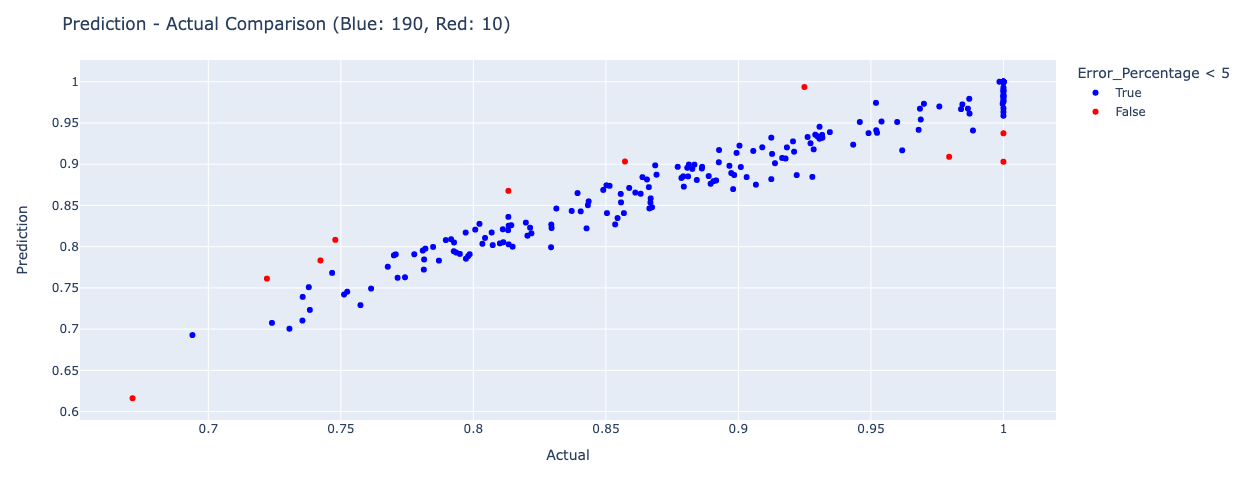

In [78]:
fig = px.scatter(res, x="Actual", y="Prediction", color = "Error_Percentage < 5", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Percentage"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

In [79]:
np.random.seed(1)
tf.random.set_seed(2)

# Scale the data
X_scaler = MaxValueScaler()
y_scaler = MaxValueScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))


ann.add(tf.keras.layers.Dense(units=1))
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')
ann.fit(X_train_scaled, y_train_scaled, batch_size = 32, epochs = 1000, verbose=1)

Epoch 1/1000
25/25 [==============================] - 0s 703us/step - loss: 0.2383
Epoch 2/1000
25/25 [==============================] - 0s 485us/step - loss: 0.0227
Epoch 3/1000
25/25 [==============================] - 0s 595us/step - loss: 0.0147
Epoch 4/1000
25/25 [==============================] - 0s 580us/step - loss: 0.0134
Epoch 5/1000
25/25 [==============================] - 0s 589us/step - loss: 0.0126
Epoch 6/1000
25/25 [==============================] - 0s 557us/step - loss: 0.0119
Epoch 7/1000
25/25 [==============================] - 0s 538us/step - loss: 0.0111
Epoch 8/1000
25/25 [==============================] - 0s 546us/step - loss: 0.0102
Epoch 9/1000
25/25 [==============================] - 0s 574us/step - loss: 0.0091
Epoch 10/1000
25/25 [==============================] - 0s 577us/step - loss: 0.0084
Epoch 11/1000
25/25 [==============================] - 0s 548us/step - loss: 0.0075
Epoch 12/1000
25/25 [==============================] - 0s 552us/step - loss: 0.0067
E

In [80]:
# Evaluate the model on the test set
y_pred_scaled = ann.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

In [81]:
# print("mean_squared_error:", mean_squared_error(y_test, y_pred)
print("neg_mean_squared_error:", mean_squared_error(y_test, y_pred, squared=False))
print("r2:", r2_score(y_test, y_pred))

neg_mean_squared_error: 0.022865459287658183
r2: 0.9261299981628858


In [82]:
prediction = y_pred

res_ann = pd.DataFrame()
res_ann["Prediction"] = pd.Series(prediction.ravel())
res_ann.loc[res_ann["Prediction"]>1, "Prediction"] = 1
res_ann["Actual"] = y_test.values
res_ann["Diff"] = res_ann.Prediction - res_ann.Actual
res_ann["Error_Percentage"] = ((res_ann.Prediction - res_ann.Actual) / res_ann.Actual) * 100 
res_ann["Error_Percentage < 5"] = np.abs(res_ann["Error_Percentage"]) < 5 
res_ann = res_ann.round(4)

res_ann

Prediction  Actual    Diff  Error_Percentage  Error_Percentage < 5
0        0.7902  0.8214 -0.0312           -3.7958                  True
1        0.9338  0.9795 -0.0457           -4.6660                  True
2        0.9505  0.9317  0.0187            2.0120                  True
3        0.8683  0.8393  0.0290            3.4600                  True
4        0.7802  0.7949 -0.0147           -1.8504                  True
..          ...     ...     ...               ...                   ...
195      0.8267  0.8132  0.0135            1.6597                  True
196      0.9811  1.0000 -0.0189           -1.8872                  True
197      0.8246  0.8432 -0.0186           -2.2030                  True
198      0.8488  0.8405  0.0083            0.9840                  True
199      0.7436  0.7379  0.0057            0.7789                  True

[200 rows x 5 columns]

In [83]:
blue = res_ann["Error_Percentage < 5"].sum()
print(blue)
red = len(res_ann["Error_Percentage < 5"]) - (res_ann["Error_Percentage < 5"].sum())
red

190


10

In [84]:
res_ann.describe()

Prediction      Actual        Diff  Error_Percentage
count  200.000000  200.000000  200.000000        200.000000
mean     0.886480    0.884756    0.001727          0.271204
std      0.079714    0.084340    0.019684          2.247234
min      0.702500    0.671400   -0.077500         -7.746800
25%      0.818375    0.813275   -0.007750         -0.853300
50%      0.889550    0.885250    0.000000          0.000000
75%      0.954050    0.960375    0.010925          1.319650
max      1.000000    1.000000    0.080300         10.284300

In [85]:
rho, p = stats.spearmanr(res_ann.Prediction, res_ann.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9694
p-Value 0.0


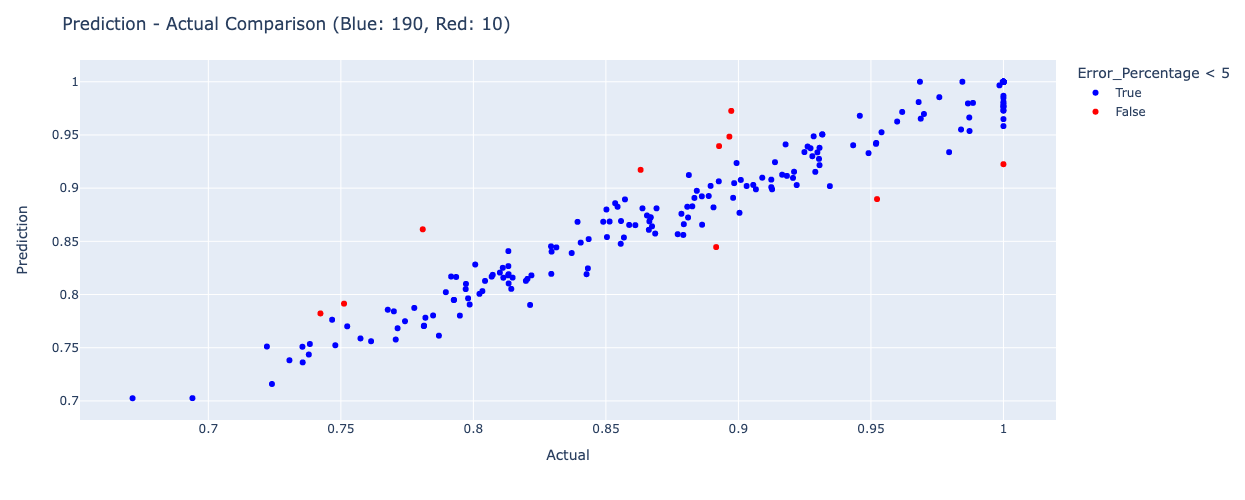

In [86]:
fig = px.scatter(res_ann, x="Actual", y="Prediction", color = "Error_Percentage < 5", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Percentage"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

### S55_IO_VRS 

In [87]:
df = pd.read_excel('Data/S55.xlsx', index_col=0)
df

Input 1  Input 2  Input 3  Input 4  Input 5  Output 1  Output 2  \
DMU 0001   140.18   303.70   235.21    22.82   122.08    102.06    314.78   
DMU 0002   147.97   263.95   125.54    29.06   162.43    100.09    329.17   
DMU 0003   141.21   264.98   368.21    28.66   214.37     99.11    414.78   
DMU 0004    95.55   244.37   251.49    30.25   135.42    118.90    303.65   
DMU 0005   116.52   271.49   214.32    29.31   284.07    150.47    299.46   
...           ...      ...      ...      ...      ...       ...       ...   
DMU 0996    72.58   281.46   318.09    17.55   201.11    123.54    354.28   
DMU 0997   137.93   310.10   186.79    33.34   227.43    125.90    402.54   
DMU 0998   124.73   244.29   361.03    25.21   153.04    108.02    415.22   
DMU 0999   135.27   277.19   164.68    27.25   168.68    142.44    396.28   
DMU 1000    98.45   277.67   277.50    13.91   161.64     97.78    295.32   

          Output 3  Output 4  Output 5  
DMU 0001     35.80     39.69    663.95  
DMU 0002     61.36     37.58    645.58  
DMU 0003     70.21     35.22    355.36  
DMU 0004     84.49     49.91    401.68  
DMU 0005     71.21     38.18    458.28  
...            ...       ...       ...  
DMU 0996     71.85     44.15    521.31  
DMU 0997    109.74     29.74    543.22  
DMU 0998     82.17     47.21    618.13  
DMU 0999     75.65     32.17    297.65  
DMU 1000     86.31     36.78    698.02  

[1000 rows x 10 columns]

In [88]:
X = df
X.head()

Input 1  Input 2  Input 3  Input 4  Input 5  Output 1  Output 2  \
DMU 0001   140.18   303.70   235.21    22.82   122.08    102.06    314.78   
DMU 0002   147.97   263.95   125.54    29.06   162.43    100.09    329.17   
DMU 0003   141.21   264.98   368.21    28.66   214.37     99.11    414.78   
DMU 0004    95.55   244.37   251.49    30.25   135.42    118.90    303.65   
DMU 0005   116.52   271.49   214.32    29.31   284.07    150.47    299.46   

          Output 3  Output 4  Output 5  
DMU 0001     35.80     39.69    663.95  
DMU 0002     61.36     37.58    645.58  
DMU 0003     70.21     35.22    355.36  
DMU 0004     84.49     49.91    401.68  
DMU 0005     71.21     38.18    458.28

In [89]:
y = pd.read_excel('Data/New/S55_Sol.xlsx', index_col=0).iloc[:,:1]
y.head()

Efficiency_Scores
DMU 0001           0.862692
DMU 0002           0.977770
DMU 0003           0.744183
DMU 0004           0.944683
DMU 0005           0.861048

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
print(X_train.shape)
print(X_test.shape)

(800, 10)
(200, 10)


In [92]:
scaler = MaxValueScaler()
reg_model = LinearRegression()

pipe_lr = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
# print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("Cross Validation metrics: ")
print("neg_root_mean_squared_error:", cross_val_score(pipe_lr, X_train, y_train, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_lr, X_train, y_train, scoring="r2").mean())

print('-' * 20)

# Train the best model on the entire training dataset
print("Holdout metrics: ")
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test.values, y_pred_lr)))
print("r2:", np.sqrt(r2_score(y_test.values, y_pred_lr)))

Cross Validation metrics: 
neg_root_mean_squared_error: -0.05439492697067967
r2: 0.6777289822046975
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.05822814427191816
r2: 0.8090057573828578


In [93]:
scaler = MaxValueScaler()

seed = 1

dt_model = DecisionTreeRegressor(random_state=seed)

pipe_dt = make_pipeline(scaler, dt_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_dt, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_dt, X_train, y_train, scoring="r2").mean())

# specify parameter values to search
params = {}
params['decisiontreeregressor__max_depth'] = list(range(1, 10)) + [None]
params['decisiontreeregressor__min_samples_split'] = list(range(2, 10, 3))
params['decisiontreeregressor__max_features'] = ["auto","log2","sqrt",None]

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_dt, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.08232521815154717
r2: 0.2876338635969457
--------------------
Cross Validation metrics: 
grid.best_score:  -0.07897438794797179
grid.best_params:  {'decisiontreeregressor__min_samples_split': 8, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__max_depth': 9}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93a0a95460>),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=9, max_features='auto',
                                       min_samples_split=8, random_state=1))])
grid.r2:  0.3193449389251928
grid.neg_root_mean_squared_error:  -0.0793776376776726
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.08685512628787617
r2: 0.48088439975140895


In [94]:
scaler = MaxValueScaler()
reg_model = KNeighborsRegressor()

pipe_knr = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
# print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("Cross Validation metrics: ")
print("neg_root_mean_squared_error:", cross_val_score(pipe_knr, X_train, y_train, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_knr, X_train, y_train, scoring="r2").mean())

print('-' * 20)

# Train the best model on the entire training dataset
print("Holdout metrics: ")
pipe_knr.fit(X_train, y_train)
y_pred_knr = pipe_knr.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test.values, y_pred_knr)))
print("r2:", np.sqrt(r2_score(y_test.values, y_pred_knr)))

Cross Validation metrics: 
neg_root_mean_squared_error: -0.0635722947267718
r2: 0.5579773026105352
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.06385049407770413
r2: 0.7645561392063311


In [95]:
scaler = MaxValueScaler()

seed = 1

rf_model = RandomForestRegressor(random_state=seed)

pipe_rf = make_pipeline(scaler, rf_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_rf, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_rf, X_train, y_train, scoring="r2").mean())

    # Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

# specify parameter values to search
params = {}
params['randomforestregressor__n_estimators'] = n_estimators
params['randomforestregressor__max_features'] = max_features
params['randomforestregressor__max_depth'] = max_depth
params['randomforestregressor__min_samples_split'] = min_samples_split
params['randomforestregressor__min_samples_leaf'] = min_samples_leaf
params['randomforestregressor__bootstrap'] = bootstrap

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_rf, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.05175795644331453
r2: 0.7187368044259852
--------------------
Cross Validation metrics: 
grid.best_score:  -0.0508245987560222
grid.best_params:  {'randomforestregressor__n_estimators': 1200, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 60, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93c5c57be0>),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=60, max_features='auto',
                                       n_estimators=1200, random_state=1))])
grid.r2:  0.7128354020325032
grid.neg_root_mean_squared_error:  -0.05153594592391566
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.05246807105331394
r2: 0.8482137904258557


In [96]:
scaler = MaxValueScaler()

seed = 1

gb_model = GradientBoostingRegressor(random_state=seed)

pipe_gb = make_pipeline(scaler, gb_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_gb, X_train, y_train, scoring="r2").mean())

learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_gb, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.04157264733750856
r2: 0.801498874354083
--------------------
Cross Validation metrics: 
grid.best_score:  -0.029167582786979156
grid.best_params:  {'gradientboostingregressor__subsample': 0.5, 'gradientboostingregressor__n_estimators': 2000, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__learning_rate': 0.01}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93c6361fd0>),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                           min_samples_split=30,
                                           n_estimators=2000, random_state=1,
                                           subsample=0.5))])
grid.r2:  0.9053033913829343
grid.neg_root_mean_squared_er

In [97]:
scaler = MaxValueScaler()

seed = 1

xgb_model = xgb.XGBRegressor(random_state=seed)

pipe_xgb = make_pipeline(scaler, xgb_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_xgb, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_xgb, X_train, y_train, scoring="r2").mean())

learning_rate = [0.01, 0.1, 0.2, 0.3]
n_estimators = [100, 500, 1000]
max_depth =  [3, 5, 6, 10, 15, 20]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)

# specify parameter values to search
params = {}
params['xgbregressor__learning_rate'] = learning_rate
params['xgbregressor__n_estimators'] = n_estimators
params['xgbregressor__max_depth'] = max_depth
params['xgbregressor__subsample'] = subsample
params['xgbregressor__colsample_bytree'] = colsample_bytree
params['xgbregressor__colsample_bylevel'] = colsample_bylevel

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_xgb, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.0466476297691065
r2: 0.7743883376044379
--------------------
Cross Validation metrics: 
grid.best_score:  -0.03501234738970934
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.2, 'xgbregressor__colsample_bytree': 0.6, 'xgbregressor__colsample_bylevel': 0.4}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93d4e13340>),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.4, colsample_bynode=1,
                              colsample_bytree=0.6, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.2,
                              max_delta_step=0, max_depth=3, min_ch

In [98]:
scaler = MaxValueScaler()

poly = PolynomialFeatures(degree=3)

# Choose regression method and set hyperparameter
reg_model=LinearRegression()

pipe_plr = make_pipeline(scaler, poly, reg_model)

# cross-validate the pipeline
# print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("Cross Validation metrics: ")
print("neg_root_mean_squared_error:", cross_val_score(pipe_plr, X_train, y_train, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_plr, X_train, y_train, scoring="r2").mean())

print('-' * 20)

# Train the best model on the entire training dataset
print("Holdout metrics: ")
pipe_plr.fit(X_train, y_train)
y_pred_plr = pipe_plr.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test.values, y_pred_plr)))
print("r2:", np.sqrt(r2_score(y_test.values, y_pred_plr)))

Cross Validation metrics: 
neg_root_mean_squared_error: -0.034962607417938656
r2: 0.8682460993480466
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.0329784005452222
r2: 0.9429586297340683


In [99]:
res = pd.DataFrame()
res["Prediction"] = pd.Series(y_pred_plr.ravel())
res.loc[res["Prediction"]>1, "Prediction"] = 1
res["Actual"] = y_test.values
res["Diff"] = res.Prediction - res.Actual
res["Error_Percentage"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Percentage < 5"] = np.abs(res["Error_Percentage"]) < 5  
res = res.round(4)
res

Prediction  Actual    Diff  Error_Percentage  Error_Percentage < 5
0        0.7725  0.7333  0.0392            5.3401                 False
1        0.9526  0.8971  0.0555            6.1899                 False
2        0.9031  0.8437  0.0594            7.0448                 False
3        0.8686  0.8730 -0.0045           -0.5102                  True
4        0.9695  0.9231  0.0465            5.0362                 False
..          ...     ...     ...               ...                   ...
195      0.6369  0.6624 -0.0255           -3.8521                  True
196      0.7718  0.7651  0.0067            0.8754                  True
197      0.8648  0.8669 -0.0021           -0.2440                  True
198      1.0000  1.0000  0.0000            0.0000                  True
199      0.8226  0.8150  0.0076            0.9347                  True

[200 rows x 5 columns]

In [100]:
blue = res["Error_Percentage < 5"].sum()
print(blue)
red = len(res["Error_Percentage < 5"]) - (res["Error_Percentage < 5"].sum())
red

181


19

In [101]:
print(res.describe())

       Prediction      Actual        Diff  Error_Percentage
count  200.000000  200.000000  200.000000        200.000000
mean     0.859170    0.859270   -0.000106          0.131881
std      0.092852    0.099312    0.029893          3.493453
min      0.623800    0.601800   -0.190700        -19.072000
25%      0.792450    0.788525   -0.012125         -1.460150
50%      0.854900    0.859050    0.000000          0.000000
75%      0.934575    0.935425    0.011025          1.381650
max      1.000000    1.000000    0.161600         21.338600


In [102]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9532
p-Value 0.0


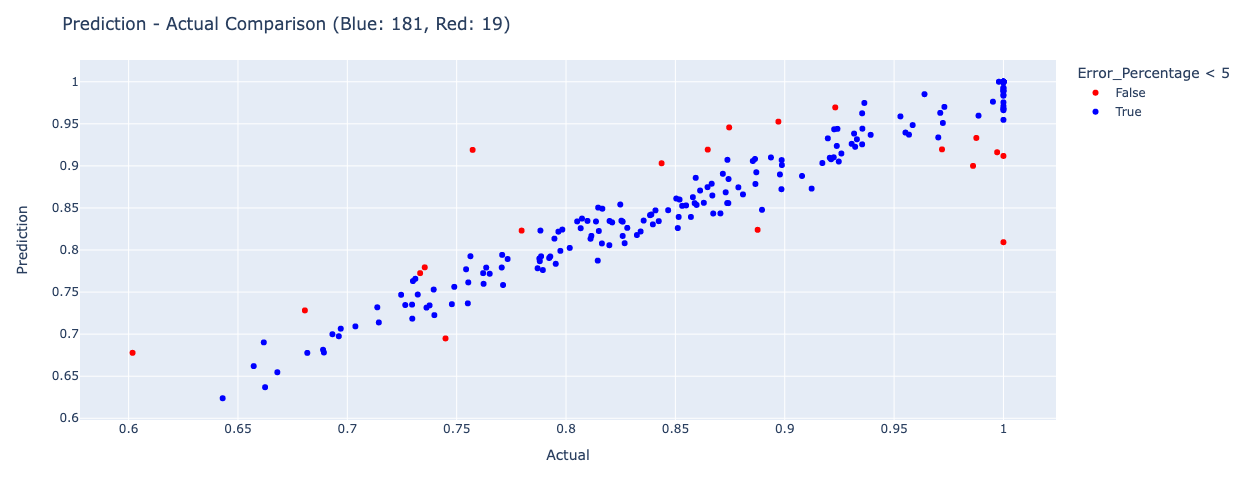

In [103]:
fig = px.scatter(res, x="Actual", y="Prediction", color = "Error_Percentage < 5", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Percentage"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

In [104]:
np.random.seed(1)
tf.random.set_seed(2)

# Scale the data
X_scaler = MaxValueScaler()
y_scaler = MaxValueScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))


ann.add(tf.keras.layers.Dense(units=1))
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')
ann.fit(X_train_scaled, y_train_scaled, batch_size = 32, epochs = 1000, verbose=1)

Epoch 1/1000
25/25 [==============================] - 0s 685us/step - loss: 0.1831
Epoch 2/1000
25/25 [==============================] - 0s 709us/step - loss: 0.0179
Epoch 3/1000
25/25 [==============================] - 0s 571us/step - loss: 0.0121
Epoch 4/1000
25/25 [==============================] - 0s 569us/step - loss: 0.0106
Epoch 5/1000
25/25 [==============================] - 0s 546us/step - loss: 0.0092
Epoch 6/1000
25/25 [==============================] - 0s 541us/step - loss: 0.0081
Epoch 7/1000
25/25 [==============================] - 0s 519us/step - loss: 0.0072
Epoch 8/1000
25/25 [==============================] - 0s 535us/step - loss: 0.0065
Epoch 9/1000
25/25 [==============================] - 0s 558us/step - loss: 0.0058
Epoch 10/1000
25/25 [==============================] - 0s 542us/step - loss: 0.0054
Epoch 11/1000
25/25 [==============================] - 0s 572us/step - loss: 0.0050
Epoch 12/1000
25/25 [==============================] - 0s 556us/step - loss: 0.0047
E

In [105]:
# Evaluate the model on the test set
y_pred_scaled = ann.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

In [106]:
# print("mean_squared_error:", mean_squared_error(y_test, y_pred)
print("neg_mean_squared_error:", mean_squared_error(y_test, y_pred, squared=False))
print("r2:", r2_score(y_test, y_pred))

neg_mean_squared_error: 0.026998788663883954
r2: 0.9257181202936968


In [107]:
prediction = y_pred

res_ann = pd.DataFrame()
res_ann["Prediction"] = pd.Series(prediction.ravel())
res_ann.loc[res_ann["Prediction"]>1, "Prediction"] = 1
res_ann["Actual"] = y_test.values
res_ann["Diff"] = res_ann.Prediction - res_ann.Actual
res_ann["Error_Percentage"] = ((res_ann.Prediction - res_ann.Actual) / res_ann.Actual) * 100 
res_ann["Error_Percentage < 5"] = np.abs(res_ann["Error_Percentage"]) < 5 
res_ann = res_ann.round(4)

res_ann

Prediction  Actual    Diff  Error_Percentage  Error_Percentage < 5
0        0.7636  0.7333  0.0302            4.1243                  True
1        0.9636  0.8971  0.0665            7.4139                 False
2        0.8465  0.8437  0.0028            0.3359                  True
3        0.8841  0.8730  0.0111            1.2675                  True
4        0.9450  0.9231  0.0220            2.3795                  True
..          ...     ...     ...               ...                   ...
195      0.6645  0.6624  0.0021            0.3127                  True
196      0.7607  0.7651 -0.0045           -0.5845                  True
197      0.8969  0.8669  0.0300            3.4614                  True
198      0.9889  1.0000 -0.0111           -1.1084                  True
199      0.7992  0.8150 -0.0157           -1.9318                  True

[200 rows x 5 columns]

In [108]:
res_ann.describe()

Prediction      Actual        Diff  Error_Percentage
count  200.000000  200.000000  200.000000        200.000000
mean     0.855811    0.859270   -0.003461         -0.316631
std      0.095397    0.099312    0.024705          2.765974
min      0.608900    0.601800   -0.148400        -14.844600
25%      0.784475    0.788525   -0.013575         -1.531575
50%      0.851750    0.859050    0.000000          0.000000
75%      0.939200    0.935425    0.009825          1.155300
max      1.000000    1.000000    0.066500          7.413900

In [109]:
rho, p = stats.spearmanr(res_ann.Prediction, res_ann.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9674
p-Value 0.0


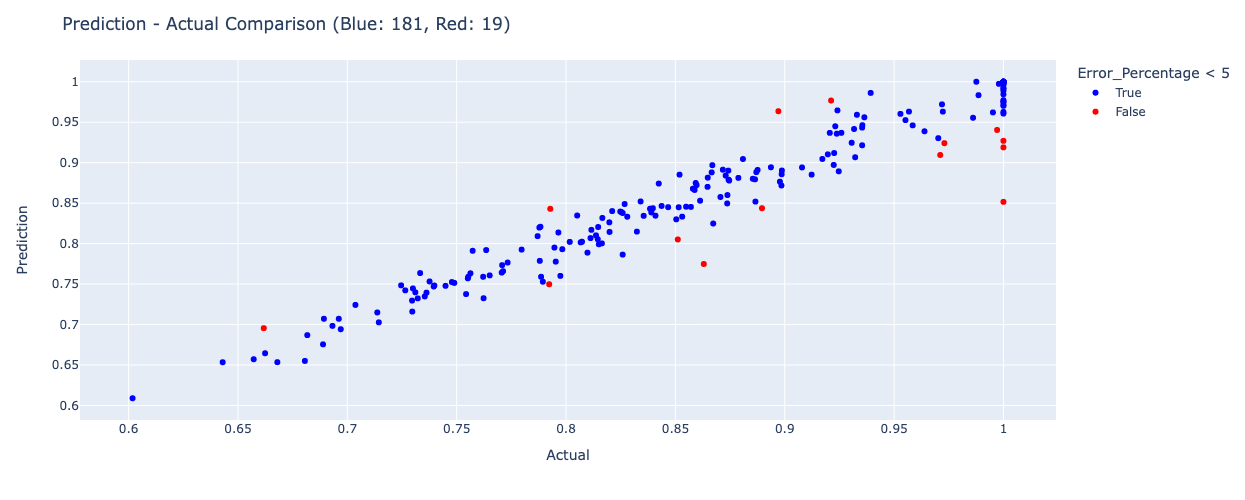

In [110]:
fig = px.scatter(res_ann, x="Actual", y="Prediction", color = "Error_Percentage < 5", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Percentage"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

### Real Data - Energy Plant Dataset

#### MaxValueScaler

In [111]:
path = "Data/RealData/"

In [112]:
df = pd.read_excel(path + 'egrid2020_data.xlsx', index_col = 0)
df

Input_Number of generators  Input_Plant nameplate capacity (MW)  \
DMU 0001                           4                                  1.5   
DMU 0002                           8                                121.4   
DMU 0003                           4                                  1.9   
DMU 0004                           6                                  2.6   
DMU 0006                           7                                 20.3   
...                              ...                                  ...   
DMU 1729                           3                                 22.5   
DMU 1730                           1                                  2.7   
DMU 1731                           1                                 40.0   
DMU 1732                           2                                  2.0   
DMU 1733                           8                                  8.4   

          Input_Plant total annual heat input (MMBtu)  \
DMU 0001                                    11554.999   
DMU 0002                                   115024.996   
DMU 0003                                    16506.999   
DMU 0004                                    26541.000   
DMU 0006                                   753573.992   
...                                               ...   
DMU 1729                                    11058.999   
DMU 1730                                     1335.000   
DMU 1731                                   168852.656   
DMU 1732                                     1299.000   
DMU 1733                                    68567.022   

          Input_Plant annual NOx emissions (tons)  \
DMU 0001                                 1212.000   
DMU 0002                                 7646.000   
DMU 0003                                 1641.999   
DMU 0004                                 2183.001   
DMU 0006                                51137.999   
...                                           ...   
DMU 1729                                  615.999   
DMU 1730                                  100.000   
DMU 1731                                15983.000   
DMU 1732                                   85.000   
DMU 1733                                11814.570   

          Input_Plant annual SO2 emissions (tons)  \
DMU 0001                                   19.200   
DMU 0002                                   18.056   
DMU 0003                                   26.523   
DMU 0004                                   44.968   
DMU 0006                                  120.560   
...                                           ...   
DMU 1729                                    1.842   
DMU 1730                                    2.134   
DMU 1731                                    4.926   
DMU 1732                                    2.078   
DMU 1733                                    9.274   

          Input_Plant annual CO2 emissions (tons)  \
DMU 0001                                    1.675   
DMU 0002                                    0.193   
DMU 0003                                    2.393   
DMU 0004                                    3.848   
DMU 0006                                    1.204   
...                                           ...   
DMU 1729                                    0.018   
DMU 1730                                    0.194   
DMU 1731                                    0.100   
DMU 1732                                    0.188   
DMU 1733                                    0.035   

          Input_Plant annual CH4 emissions (lbs)  \
DMU 0001                                 943.616   
DMU 0002                                6724.603   
DMU 0003                                1348.008   
DMU 0004                                2167.415   
DMU 0006                               44042.277   
...                                          ...   
DMU 1729                                 646.338   
DMU 1730                                 109.020   
DMU 1731             

In [113]:
df.shape

(1644, 9)

In [114]:
X = df
X.head()

Input_Number of generators  Input_Plant nameplate capacity (MW)  \
DMU 0001                           4                                  1.5   
DMU 0002                           8                                121.4   
DMU 0003                           4                                  1.9   
DMU 0004                           6                                  2.6   
DMU 0006                           7                                 20.3   

          Input_Plant total annual heat input (MMBtu)  \
DMU 0001                                    11554.999   
DMU 0002                                   115024.996   
DMU 0003                                    16506.999   
DMU 0004                                    26541.000   
DMU 0006                                   753573.992   

          Input_Plant annual NOx emissions (tons)  \
DMU 0001                                 1212.000   
DMU 0002                                 7646.000   
DMU 0003                                 1641.999   
DMU 0004                                 2183.001   
DMU 0006                                51137.999   

          Input_Plant annual SO2 emissions (tons)  \
DMU 0001                                   19.200   
DMU 0002                                   18.056   
DMU 0003                                   26.523   
DMU 0004                                   44.968   
DMU 0006                                  120.560   

          Input_Plant annual CO2 emissions (tons)  \
DMU 0001                                    1.675   
DMU 0002                                    0.193   
DMU 0003                                    2.393   
DMU 0004                                    3.848   
DMU 0006                                    1.204   

          Input_Plant annual CH4 emissions (lbs)  \
DMU 0001                                 943.616   
DMU 0002                                6724.603   
DMU 0003                                1348.008   
DMU 0004                                2167.415   
DMU 0006                               44042.277   

          Input_Plant annual N2O emissions (lbs)  \
DMU 0001                                  76.423   
DMU 0002                                 262.106   
DMU 0003                                 109.175   
DMU 0004                                 175.539   
DMU 0006                                1661.692   

          Output_Plant annual net generation (MWh)  
DMU 0001                                    15.285  
DMU 0002                                    27.488  
DMU 0003                                    21.835  
DMU 0004                                    35.108  
DMU 0006                                   166.221

In [115]:
y = pd.read_excel("Data/RealData/egrid2020_data_Sol.xlsx", index_col=0).iloc[:,:1]
y.head()

Efficiency_Scores
DMU 0001           0.728929
DMU 0002           0.319788
DMU 0003           0.745540
DMU 0004           0.797534
DMU 0006           0.302185

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
print(X_train.shape)
print(X_test.shape)

(1315, 9)
(329, 9)


In [118]:
scaler = MaxValueScaler()
reg_model = LinearRegression()

pipe_lr = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
# print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("Cross Validation metrics: ")
print("neg_root_mean_squared_error:", cross_val_score(pipe_lr, X_train, y_train, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_lr, X_train, y_train, scoring="r2").mean())

print('-' * 20)

# Train the best model on the entire training dataset
print("Holdout metrics: ")
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test.values, y_pred_lr)))
print("r2:", np.sqrt(r2_score(y_test.values, y_pred_lr)))

Cross Validation metrics: 
neg_root_mean_squared_error: -0.20899214930760604
r2: 0.2550402343646702
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.20173945605995963
r2: 0.5075133999122751


In [119]:
scaler = MaxValueScaler()

seed = 1

dt_model = DecisionTreeRegressor(random_state=seed)

pipe_dt = make_pipeline(scaler, dt_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_dt, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_dt, X_train, y_train, scoring="r2").mean())

# specify parameter values to search
params = {}
params['decisiontreeregressor__max_depth'] = list(range(1, 10)) + [None]
params['decisiontreeregressor__min_samples_split'] = list(range(2, 10, 3))
params['decisiontreeregressor__max_features'] = ["auto","log2","sqrt",None]

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_dt, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.09649801662995126
r2: 0.8211843460647072
--------------------
Cross Validation metrics: 
grid.best_score:  -0.09748307499595134
grid.best_params:  {'decisiontreeregressor__min_samples_split': 2, 'decisiontreeregressor__max_features': None, 'decisiontreeregressor__max_depth': None}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93d4e9a460>),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=1))])
grid.r2:  0.8404012721072179
grid.neg_root_mean_squared_error:  -0.09649801662995126
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.09589149809503142
r2: 0.9122833849559753


In [120]:
scaler = MaxValueScaler()
reg_model = KNeighborsRegressor()

pipe_knr = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
# print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("Cross Validation metrics: ")
print("neg_root_mean_squared_error:", cross_val_score(pipe_knr, X_train, y_train, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_knr, X_train, y_train, scoring="r2").mean())

print('-' * 20)

# Train the best model on the entire training dataset
print("Holdout metrics: ")
pipe_knr.fit(X_train, y_train)
y_pred_knr = pipe_knr.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test.values, y_pred_knr)))
print("r2:", np.sqrt(r2_score(y_test.values, y_pred_knr)))

Cross Validation metrics: 
neg_root_mean_squared_error: -0.14836901839189692
r2: 0.6237569043579194
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.11611952669677761
r2: 0.868348264186627


In [121]:
scaler = MaxValueScaler()

seed = 1

rf_model = RandomForestRegressor(random_state=seed)

pipe_rf = make_pipeline(scaler, rf_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_rf, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_rf, X_train, y_train, scoring="r2").mean())

    # Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

# specify parameter values to search
params = {}
params['randomforestregressor__n_estimators'] = n_estimators
params['randomforestregressor__max_features'] = max_features
params['randomforestregressor__max_depth'] = max_depth
params['randomforestregressor__min_samples_split'] = min_samples_split
params['randomforestregressor__min_samples_leaf'] = min_samples_leaf
params['randomforestregressor__bootstrap'] = bootstrap

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_rf, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.07594644128081028
r2: 0.895330743887078
--------------------
Cross Validation metrics: 
grid.best_score:  -0.0682542096781007
grid.best_params:  {'randomforestregressor__n_estimators': 1600, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': False}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93c63d2cd0>),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=False, max_depth=100,
                                       max_features='sqrt',
                                       min_samples_split=10, n_estimators=1600,
                                       random_state=1))])
grid.r2:  0.91026900202685
grid.neg_root_mean_squared_error:  -0.07198734140230582
-------------

In [122]:
scaler = MaxValueScaler()

seed = 1

xgb_model = xgb.XGBRegressor(random_state=seed)

pipe_xgb = make_pipeline(scaler, xgb_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_xgb, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_xgb, X_train, y_train, scoring="r2").mean())

learning_rate = [0.01, 0.1, 0.2, 0.3]
n_estimators = [100, 500, 1000]
max_depth =  [3, 5, 6, 10, 15, 20]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)

# specify parameter values to search
params = {}
params['xgbregressor__learning_rate'] = learning_rate
params['xgbregressor__n_estimators'] = n_estimators
params['xgbregressor__max_depth'] = max_depth
params['xgbregressor__subsample'] = subsample
params['xgbregressor__colsample_bytree'] = colsample_bytree
params['xgbregressor__colsample_bylevel'] = colsample_bylevel

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_xgb, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.06936497341964443
r2: 0.9163555614475856
--------------------
Cross Validation metrics: 
grid.best_score:  -0.06304839272654564
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.2, 'xgbregressor__colsample_bytree': 0.6, 'xgbregressor__colsample_bylevel': 0.4}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93a09d8250>),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.4, colsample_bynode=1,
                              colsample_bytree=0.6, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.2,
                              max_delta_step=0, max_depth=3, min_c

In [123]:
scaler = MaxValueScaler()

poly = PolynomialFeatures(degree=2)

# Choose regression method and set hyperparameter
reg_model=LinearRegression()

pipe_plr = make_pipeline(scaler, poly, reg_model)

# cross-validate the pipeline
# print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("Cross Validation metrics: ")
print("neg_root_mean_squared_error:", cross_val_score(pipe_plr, X_train, y_train, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_plr, X_train, y_train, scoring="r2").mean())

print('-' * 20)

# Train the best model on the entire training dataset
print("Holdout metrics: ")
pipe_plr.fit(X_train, y_train)
y_pred_plr = pipe_plr.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test.values, y_pred_plr)))
print("r2:", np.sqrt(r2_score(y_test.values, y_pred_plr)))

Cross Validation metrics: 
neg_root_mean_squared_error: -0.26112397756583844
r2: -0.1965820120126341
--------------------
Holdout metrics: 
neg_root_mean_squared_error: 0.17202780609476748
r2: 0.6783453076981873


In [124]:
scaler = MaxValueScaler()

seed = 1

gb_model = GradientBoostingRegressor(random_state=seed)

pipe_gb = make_pipeline(scaler, gb_model)

kfold = KFold(n_splits=5, random_state=seed, shuffle = True)

# cross-validate the pipeline
print("Deafult metrics: ")
# print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())
print("r2:", cross_val_score(pipe_gb, X_train, y_train, scoring="r2").mean())

learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

np.random.seed(seed)
grid = RandomizedSearchCV(pipe_gb, params, cv=kfold, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print('-' * 20)

print("Cross Validation metrics: ")
print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="r2", cv = kfold).mean())
print("grid.neg_root_mean_squared_error: ", cross_val_score(grid.best_estimator_, X_train, y_train, scoring="neg_root_mean_squared_error", cv = kfold).mean())

print('-' * 20)

print("Holdout metrics: ")
grid.best_estimator_.fit(X_train, y_train)
y_pred = grid.best_estimator_.predict(X_test)
print("neg_root_mean_squared_error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2:", np.sqrt(r2_score(y_test, y_pred)))

Deafult metrics: 
neg_root_mean_squared_error: -0.07670331165759463
r2: 0.8937023889787377
--------------------
Cross Validation metrics: 
grid.best_score:  -0.05218672894770351
grid.best_params:  {'gradientboostingregressor__subsample': 0.5, 'gradientboostingregressor__n_estimators': 2000, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__learning_rate': 0.01}
grid.best_estimator:  Pipeline(steps=[('maxvaluescaler',
                 <__main__.MaxValueScaler object at 0x7f93d4eda070>),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                           min_samples_split=30,
                                           n_estimators=2000, random_state=1,
                                           subsample=0.5))])
grid.r2:  0.9435528351193243
grid.neg_root_mean_squared_er

In [125]:
res = pd.DataFrame()
res["Prediction"] = pd.Series(y_pred.ravel())
res.loc[res["Prediction"]>1, "Prediction"] = 1
res["Actual"] = y_test.values
res["Diff"] = res.Prediction - res.Actual
res["Error_Percentage"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Percentage < 5"] = np.abs(res["Error_Percentage"]) < 5  
res = res.round(4)
res

Prediction  Actual    Diff  Error_Percentage  Error_Percentage < 5
0        0.7502  0.7482  0.0020            0.2688                  True
1        0.2604  0.2515  0.0089            3.5303                  True
2        0.4314  0.4298  0.0016            0.3674                  True
3        0.7546  0.7556 -0.0011           -0.1405                  True
4        0.4008  0.3937  0.0071            1.7963                  True
..          ...     ...     ...               ...                   ...
324      0.3783  0.3779  0.0004            0.1039                  True
325      0.9877  0.9991 -0.0113           -1.1330                  True
326      0.3440  0.4040 -0.0601          -14.8649                 False
327      0.2542  0.2403  0.0139            5.8040                 False
328      0.7458  0.7206  0.0251            3.4845                  True

[329 rows x 5 columns]

In [126]:
blue = res["Error_Percentage < 5"].sum()
print(blue)
red = len(res["Error_Percentage < 5"]) - (res["Error_Percentage < 5"].sum())
red

226


103

In [127]:
print(res.describe())

       Prediction      Actual        Diff  Error_Percentage
count  329.000000  329.000000  329.000000        329.000000
mean     0.503012    0.502691    0.000323          1.275216
std      0.227026    0.234488    0.038171          8.741080
min      0.212300    0.222900   -0.230200        -39.965700
25%      0.292100    0.281300   -0.010900         -1.910000
50%      0.448200    0.450900    0.002000          0.304400
75%      0.732500    0.732500    0.013300          3.633400
max      1.000000    1.000000    0.173600         50.914300


In [128]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9809
p-Value 0.0


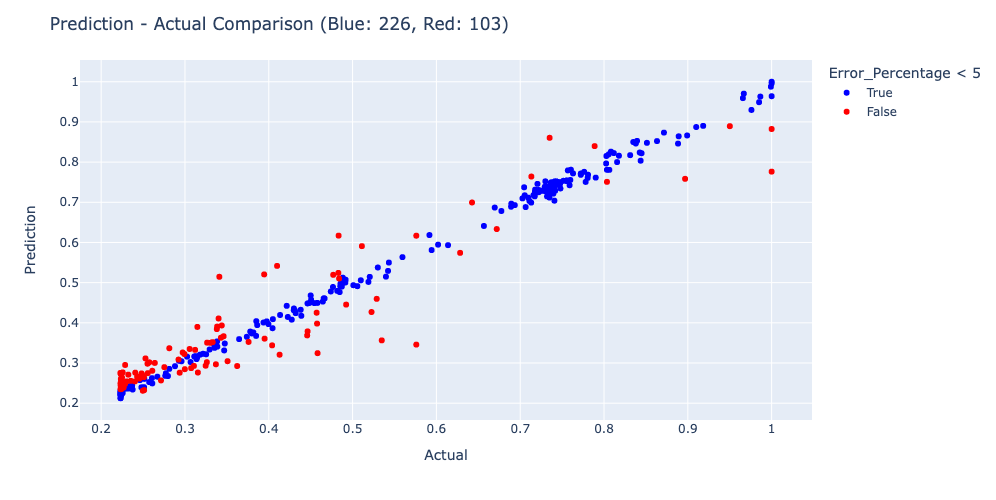

In [129]:
fig = px.scatter(res, x="Actual", y="Prediction", color = "Error_Percentage < 5", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Percentage"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

In [130]:
np.random.seed(1)
tf.random.set_seed(2)

# Scale the data
X_scaler = MaxValueScaler()
y_scaler = MaxValueScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))

ann.add(tf.keras.layers.Dense(units=1))
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')
ann.fit(X_train_scaled, y_train_scaled, batch_size = 32, epochs = 1000, verbose=1)

Epoch 1/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.1142
Epoch 2/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0440
Epoch 3/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0336
Epoch 4/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0272
Epoch 5/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0268
Epoch 6/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0230
Epoch 7/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0210
Epoch 8/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0194
Epoch 9/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 10/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0185
Epoch 11/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0180
Epoch 12/1000
42/42 [==============================] - 0s 1ms/step - loss: 0.0174
Epoch 13/1000
42/42 [====

In [131]:
# Evaluate the model on the test set
y_pred_scaled = ann.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

In [132]:
# print("mean_squared_error:", mean_squared_error(y_test, y_pred)
print("neg_mean_squared_error:", mean_squared_error(y_test, y_pred, squared=False))
print("r2:", r2_score(y_test, y_pred))

neg_mean_squared_error: 0.0947351124981166
r2: 0.8362822155262666


In [133]:
prediction = y_pred

res_ann = pd.DataFrame()
res_ann["Prediction"] = pd.Series(prediction.ravel())
res_ann.loc[res_ann["Prediction"]>1, "Prediction"] = 1
res_ann["Actual"] = y_test.values
res_ann["Diff"] = res_ann.Prediction - res_ann.Actual
res_ann["Error_Percentage"] = ((res_ann.Prediction - res_ann.Actual) / res_ann.Actual) * 100 
res_ann["Error_Percentage < 5"] = np.abs(res_ann["Error_Percentage"]) < 5 
res_ann = res_ann.round(4)

res_ann

Prediction  Actual    Diff  Error_Percentage  Error_Percentage < 5
0        0.6820  0.7482 -0.0661           -8.8402                 False
1        0.2404  0.2515 -0.0111           -4.4275                  True
2        0.4306  0.4298  0.0008            0.1894                  True
3        0.6810  0.7556 -0.0747           -9.8827                 False
4        0.4261  0.3937  0.0323            8.2160                 False
..          ...     ...     ...               ...                   ...
324      0.3682  0.3779 -0.0096           -2.5529                  True
325      0.9974  0.9991 -0.0017           -0.1655                  True
326      0.3237  0.4040 -0.0803          -19.8820                 False
327      0.2389  0.2403 -0.0014           -0.5874                  True
328      0.7315  0.7206  0.0108            1.5015                  True

[329 rows x 5 columns]

In [134]:
blue = res_ann["Error_Percentage < 5"].sum()
print(blue)
red = len(res_ann["Error_Percentage < 5"]) - (res_ann["Error_Percentage < 5"].sum())
red

156


173

In [135]:
res_ann.describe()

Prediction      Actual        Diff  Error_Percentage
count  329.000000  329.000000  329.000000        329.000000
mean     0.497884    0.502691   -0.004812          1.397993
std      0.225656    0.234488    0.094759         19.187618
min      0.203200    0.222900   -0.748900        -74.889400
25%      0.277500    0.281300   -0.020100         -4.662800
50%      0.449000    0.450900    0.005100          1.056600
75%      0.731500    0.732500    0.019600          5.903500
max      0.998700    1.000000    0.603800        153.060900

In [136]:
rho, p = stats.spearmanr(res_ann.Prediction, res_ann.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9117
p-Value 0.0


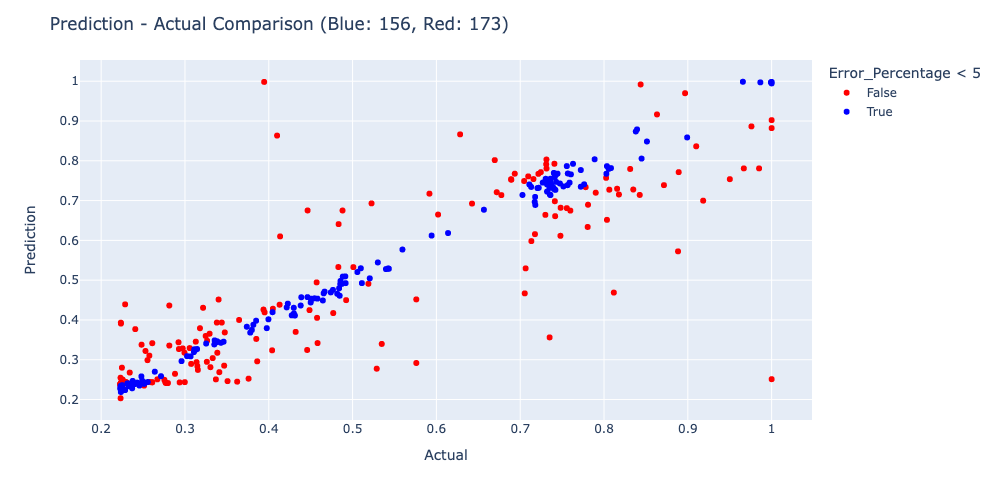

In [137]:
fig = px.scatter(res_ann, x="Actual", y="Prediction", color = "Error_Percentage < 5", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Percentage"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()